## Libraries and Pretrained Models

In [64]:
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#!python -m torch.utils.collect_env

In [65]:
import torch
use_cuda = torch.cuda.is_available()
if use_cuda:
 print('__CUDNN VERSION:', torch.backends.cudnn.version())
 print('__Number CUDA Devices:', torch.cuda.device_count())
 print('__CUDA Device Name:',torch.cuda.get_device_name(0))
 print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 8700
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
__CUDA Device Total Memory [GB]: 4.294443008


In [67]:
## for model aware decoder
%pip install git+https://github.com/otaheri/MANO

## for importing bert models used for embedding 'R', 'L' tokens
%pip install transformers




  Cloning https://github.com/otaheri/MANO to c:\users\haith\appdata\local\temp\pip-req-build-mvw6twm8
  Resolved https://github.com/otaheri/MANO to commit b1a7e5a1906cf9069dc34abc2b1728b17fa8fade
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/otaheri/MANO 'C:\Users\haith\AppData\Local\Temp\pip-req-build-mvw6twm8'

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
%pip install pyarrow matplotlib pandas scikit-learn tqdm


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [138]:
import sys
sys.path.append('/kaggle/input/manolibraries')
import torch

import torch.nn as nn
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import gc
import os
import time
import math
from torch.utils.data import DataLoader,RandomSampler
import torch.optim.lr_scheduler as lr_scheduler
import glob




## Configurations

In [167]:
#root_dir= '/content/drive/MyDrive/Projects/CMP719'
#root_dir='/kaggle/input'
root_dir='.'

mano_model_path = f'{root_dir}/mano-models/mano_v1_2/models'


device = torch.device("cpu")
if torch.cuda.is_available():
	device = torch.device("cuda")

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict()

args_dict = {

            'wlasl_dataset':'/wlasl-dataset/estimated_keypoints',
            'autsl_dataset': '/autsl-dataset/train_keypoints',
            'train_labels': '/autsl-dataset',
            'max_frames' : 64, # Max number of frames in each file
            "point_dim"  : 42, # 21(L or R landmarks) * 2(x,y)
            'embed_dim'  : 256,
            'num_head'   : 4,
            'num_block'  : 3,
            'batch_size' : 32,  #64 or 32
           
            'label_smoothing' : 0.5,
            'start_lr': 0.001, #1e-4 #0.0001
            'lr_reduce_factor': 0.1,
            'lr_red_epoch_num': 10,
            'momentum':0.9,
            'weight_decay':0.0001,
            'dropout':0,
            'mask_threshold':0,
            'epochs':30,
            'num_classes': 226,
            'model_name': 'EncoderTransformer',
            'experiment_name': 'ISLR Classification Task from Scratch'

}
args.update(args_dict)


# Dataset

In [141]:
# I use Mediapipe tool for pose estimation of keypoints in frames. This tool give coodinates of 21 keypoints in every hand.
# For every video, Parquet file are generated by Mediapipe tool.
# Each parquet file contain the following information: FrameNo, Frame Height/wight, coordinates (x,y,z) of every keypoint estimated.
# As result every frame has 42 rows for the keypoints information.

import numpy as np
import tqdm.notebook
from tqdm.notebook import tqdm

#extension = "mp4.to_parquet"
extension = "_color.mp4.to_parquet"
ROWS_PER_FRAME = 42  # number of landmarks per frame
LHAND = np.arange(0, 21).tolist() # 21
RHAND = np.arange(21, 42).tolist() # 21

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data = data.fillna(0)
   
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    
    return data.astype(np.float32)


# Get complete file path to file
def get_file_path(file_name):
    return f'{root_dir}{args.autsl_dataset}/{file_name}{extension}'


#for idx, file_path in enumerate(tqdm(train_df['file_path'])):
    #df = pd.read_parquet(file_path)
#print('df',df)


class SignDataset(Dataset):
    def __init__(self, df, pretrain=True):
        self.df = df
        self.length = len(self.df)
        self.pretrain=pretrain
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        file_info = self.df.iloc[index]

        #pq_file = d.file_path
        
        FKC = load_relevant_data_subset(file_info.file_path)[...,:2]
   
        FKC = torch.from_numpy(FKC).float()
      
        if self.pretrain == True:
            return FKC
        else:
            return FKC, file_info.sign_ord







# Embeddings

## GCN Embedding

### Graph Model

In [142]:
import numpy as np

class Graph():
    """ The Graph to model the skeletons of human body/hand

    Args:
        strategy (string): must be one of the follow candidates
        - spatial: Clustered Configuration


        layout (string): must be one of the follow candidates
        - 'hand21' same with ground truth structure of human , with 21 joints per frame


        max_hop (int): the maximal distance between two connected nodes
        dilation (int): controls the spacing between the kernel points

    """

    def __init__(self,
                 layout,
                 strategy,
                 pad=0,
                 max_hop=1,
                 dilation=1):

        self.max_hop = max_hop
        self.dilation = dilation
        self.seqlen = 2*pad+1
        self.get_edge(layout)
        self.hop_dis = get_hop_distance(self.num_node, self.edge, max_hop=max_hop)

        # get distance of each node to center
        self.dist_center = self.get_distance_to_center(layout)
        self.get_adjacency(strategy)

    def get_distance_to_center(self,layout):
        """

        :return: get the distance of each node to center
        """
        dist_center = np.zeros(self.num_node)
        if layout == 'hand21':
            for i in range(self.seqlen):
                index_start = i*self.num_node_each
                dist_center[index_start+0 : index_start+5]  =  [0, 1, 2, 3, 4]
                dist_center[index_start+5 : index_start+9]  =  [1, 2, 3, 4]
                dist_center[index_start+9 : index_start+13] =  [1, 2, 3, 4]
                dist_center[index_start+13 : index_start+17]=  [1, 2, 3, 4]
                dist_center[index_start+17 : index_start+21]=  [1, 2, 3, 4]
        return dist_center


    def __str__(self):
        return self.A

    def graph_link_between_frames(self,base):
        """
        calculate graph link between frames given base nodes and seq_ind
        :param base:
        :return:
        """
        return [((front - 1) + i*self.num_node_each, (back - 1)+ i*self.num_node_each) for i in range(self.seqlen) for (front, back) in base]


    def basic_layout(self,neighbour_base, sym_base):
        """
        for generating basic layout time link selflink etc.
        neighbour_base: neighbour link per frame
        sym_base: symmetrical link(for body) or cross-link(for hand) per frame

        :return: link each node with itself
        """
        self.num_node = self.num_node_each * self.seqlen

        time_link = [(i * self.num_node_each + j, (i + 1) * self.num_node_each + j) for i in range(self.seqlen - 1)
                     for j in range(self.num_node_each)]
        self.time_link_forward = [(i * self.num_node_each + j, (i + 1) * self.num_node_each + j) for i in
                                  range(self.seqlen - 1)
                                  for j in range(self.num_node_each)]
        self.time_link_back = [((i + 1) * self.num_node_each + j, (i) * self.num_node_each + j) for i in
                               range(self.seqlen - 1)
                               for j in range(self.num_node_each)]

        self_link = [(i, i) for i in range(self.num_node)]

        self.neighbour_link_all = self.graph_link_between_frames(neighbour_base)

        self.sym_link_all = self.graph_link_between_frames(sym_base)

        return self_link, time_link

    def get_edge(self, layout):


        """
        get edge link of the graph
        la,ra: left/right arm
        ll/rl: left/right leg
        cb: center bone
        """
        if layout == 'hand21':
            self.num_node_each = 21


            neighbour_base = [ (2, 3), (3, 4), (4, 5), (1, 6), (6, 7), (7, 8),
                               (8, 9), (10, 11), (11, 12), (12, 13),
                              (14, 15), (15, 16), (16, 17),  (18, 19), (19, 20),
                    (20, 21), (1, 2),(1, 6),(1, 10),(1, 14), (18, 1)]
            sym_base = [(2, 6),(3, 7),(4, 8),(5, 9),(14, 18),(6, 10),(7, 11),(8, 12),(9, 13),
                        (10, 14),(11, 15),(12, 16),(13, 17),(14, 18),(15, 19),(16, 20),(17, 21)]

            self_link, time_link = self.basic_layout(neighbour_base, sym_base)

            self.p1, self.p2 =[2, 3, 4], [6, 7, 8]
            self.p3, self.p4 = [10, 11, 12 ], [14, 15, 16]
            self.p5 = [18, 19, 20]
            self.cb = [0, 1, 5, 9, 13, 17]
            self.part = [self.p1, self.p2, self.p3, self.p4, self.p5, self.cb]

            self.edge = self_link + self.neighbour_link_all + self.sym_link_all + time_link

            # center node of body/hand
            self.center = 0  # node 8 is the root or center

        else:
            raise ValueError("Do Not Exist This Layout.")

    def get_adjacency(self, strategy):

        valid_hop = range(0, self.max_hop + 1, self.dilation)
        adjacency = np.zeros((self.num_node, self.num_node))
        for hop in valid_hop:
            adjacency[self.hop_dis == hop] = 1
        normalize_adjacency = normalize_digraph(adjacency)



        if strategy == 'spatial':
            A = []
            for hop in valid_hop:
                a_root = np.zeros((self.num_node, self.num_node))
                a_close = np.zeros((self.num_node, self.num_node))
                a_further = np.zeros((self.num_node, self.num_node))
                a_sym = np.zeros((self.num_node, self.num_node))
                a_forward = np.zeros((self.num_node, self.num_node))
                a_back = np.zeros((self.num_node, self.num_node))
                for i in range(self.num_node):
                    for j in range(self.num_node):
                        if self.hop_dis[j, i] == hop:
                            if (j,i) in self.sym_link_all or (i,j) in self.sym_link_all:
                                a_sym[j, i] = normalize_adjacency[j, i]
                            elif (j,i) in self.time_link_forward:
                                a_forward[j, i] = normalize_adjacency[j, i]
                            elif (j,i) in self.time_link_back:
                                a_back[j, i] = normalize_adjacency[j, i]
                            elif self.dist_center[j] == self.dist_center[i]:
                                a_root[j, i] = normalize_adjacency[j, i]
                            elif self.dist_center[j] > self.dist_center[i]:
                                a_close[j, i] = normalize_adjacency[j, i]
                            else:
                                a_further[j, i] = normalize_adjacency[j, i]
                if hop == 0:
                    A.append(a_root)
                else:
                    A.append(a_close)
                    A.append(a_further)
                    A.append(a_sym)
                    if self.seqlen > 1:
                        A.append(a_forward)
                        A.append(a_back)
            A = np.stack(A)

            self.A = A

        else:
            raise ValueError("Do Not Exist This Strategy")


def get_hop_distance(num_node, edge, max_hop=1):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1

    # compute hop steps
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(max_hop + 1)]# GET [I,A]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(max_hop, -1, -1): # preserve A(i,j) = 1 while A(i,i) = 0
        hop_dis[arrive_mat[d]] = d
    return hop_dis


def normalize_digraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    AD = np.dot(A, Dn)
    return AD


def normalize_undigraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-0.5)
    DAD = np.dot(np.dot(Dn, A), Dn)
    return DAD

### Graph Pooling

In [143]:

import numpy as np

class Graph_pool():
    """ The Graph to model the skeletons of human body/hand

    Args:
        strategy (string): must be one of the follow candidates
        - spatial: Clustered Configuration

        layout (string): must be one of the follow candidates
        - 'hand21' same with ground truth structure of human 3.6 , with 17 joints per frame

        max_hop (int): the maximal distance between two connected nodes
        dilation (int): controls the spacing between the kernel points

    """

    def __init__(self,
                 layout,
                 strategy,
                 pad=0,
                 max_hop=1,
                 dilation=1):
        self.max_hop = max_hop
        self.dilation = dilation
        self.seqlen = 2*pad+1
        self.get_edge(layout)
        self.hop_dis = get_hop_distance(
            self.num_node, self.edge, max_hop=max_hop)

        # get distance of each node to center
        self.dist_center = self.get_distance_to_center(layout)
        self.get_adjacency(strategy)

    def get_distance_to_center(self,layout):
        """

        :return: get the distance of each node to center
        """
        dist_center = np.zeros(self.num_node)
        if layout == 'hand21':
            for i in range(self.seqlen):
                index_start = i*self.num_node_each
                dist_center[index_start+ 0:index_start+6] = [0,1,1,1,1,1]
                #dist_center[index_start+5] = 0
        return dist_center

    def __str__(self):
        return self.A
    def graph_link_between_frames(self,base):
        """
        calculate graph link between frames given base nodes and seq_ind
        :param base:
        :return:
        """
        return [((front ) + i*self.num_node_each, (back )+ i*self.num_node_each) for i in range(self.seqlen) for (front, back) in base]

    def get_edge(self, layout):

        if layout == 'hand21' :
            self.num_node_each = 6

            self.num_node = self.num_node_each * self.seqlen
            time_link = [(i * self.num_node_each + j, (i + 1) * self.num_node_each + j) for i in range(self.seqlen - 1)
                         for j in range(self.num_node_each)]
            self.time_link_forward = [(i * self.num_node_each + j, (i + 1) * self.num_node_each + j) for i in range(self.seqlen - 1)
                         for j in range(self.num_node_each)]
            self.time_link_back = [((i+1) * self.num_node_each + j, (i) * self.num_node_each + j) for i in range(self.seqlen - 1)
                         for j in range(self.num_node_each)]
            self_link = [(i, i) for i in range(self.num_node)]

            neighbour_base = [(0,1), (0, 2), (0, 3), (0, 4),(0, 5)]
            sym_base = [(1, 2),(2, 3),(3, 4),(4, 5)]




            self.neighbour_link_all = self.graph_link_between_frames(neighbour_base)
            self.sym_link_all = self.graph_link_between_frames(sym_base)

            self.edge = self_link + self.neighbour_link_all + self.sym_link_all + time_link

             #center bone
            self.center = 1-1


        else:
            raise ValueError("Do Not Exist This Layout.")

    def get_adjacency(self, strategy):
        valid_hop = range(0, self.max_hop + 1, self.dilation)
        adjacency = np.zeros((self.num_node, self.num_node))
        for hop in valid_hop:
            adjacency[self.hop_dis == hop] = 1
        normalize_adjacency = normalize_digraph(adjacency)


        if strategy == 'spatial':
            A = []
            for hop in valid_hop:
                a_root = np.zeros((self.num_node, self.num_node))
                a_close = np.zeros((self.num_node, self.num_node))
                a_further = np.zeros((self.num_node, self.num_node))
                a_sym = np.zeros((self.num_node, self.num_node))
                a_forward = np.zeros((self.num_node, self.num_node))
                a_back = np.zeros((self.num_node, self.num_node))
                for i in range(self.num_node):
                    for j in range(self.num_node):
                        if self.hop_dis[j, i] == hop:
                            if (j,i) in self.sym_link_all or (i,j) in self.sym_link_all:
                                a_sym[j, i] = normalize_adjacency[j, i]
                            elif (j,i) in self.time_link_forward:
                                a_forward[j, i] = normalize_adjacency[j, i]
                            elif (j,i) in self.time_link_back:
                                a_back[j, i] = normalize_adjacency[j, i]
                            elif self.dist_center[j] == self.dist_center[i]:
                                a_root[j, i] = normalize_adjacency[j, i]
                            elif self.dist_center[j] > self.dist_center[i]:
                                a_close[j, i] = normalize_adjacency[j, i]
                            else:
                                a_further[j, i] = normalize_adjacency[j, i]
                if hop == 0:
                    A.append(a_root)
                else:
                    A.append(a_close)
                    A.append(a_further)
                    A.append(a_sym)
                    if self.seqlen > 1:
                        A.append(a_forward)
                        A.append(a_back)
            A = np.stack(A)
            self.A = A

        else:
            raise ValueError("Do Not Exist This Strategy")


def get_hop_distance(num_node, edge, max_hop=1):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1

    # compute hop steps
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(max_hop + 1)]# GET [I,A]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(max_hop, -1, -1):# preserve A(i,j) = 1 while A(i,i) = 0
        hop_dis[arrive_mat[d]] = d
    return hop_dis


def normalize_digraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    AD = np.dot(A, Dn)
    return AD


def normalize_undigraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-0.5)
    DAD = np.dot(np.dot(Dn, A), Dn)
    return DAD

### Non Local Block

In [144]:
import torch
from torch import nn
from torch.nn import functional as F


class _NonLocalBlockND(nn.Module):
    def __init__(self, in_channels, inter_channels=None, dimension=3, sub_sample=True, bn_layer=True):
        super(_NonLocalBlockND, self).__init__()

        assert dimension in [1, 2, 3]

        self.dimension = dimension
        self.sub_sample = sub_sample

        self.in_channels = in_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            max_pool_layer = nn.MaxPool3d(kernel_size=(1, 2, 2))
            bn = nn.BatchNorm3d
        elif dimension == 2:
            conv_nd = nn.Conv2d
            max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
            bn = nn.BatchNorm2d
        else:
            conv_nd = nn.Conv1d
            max_pool_layer = nn.MaxPool1d(kernel_size=(2))
            bn = nn.BatchNorm1d

        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                         kernel_size=1, stride=1, padding=0)

        if bn_layer:
            self.W = nn.Sequential(
                conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                        kernel_size=1, stride=1, padding=0),
                bn(self.in_channels)
            )
            nn.init.constant_(self.W[1].weight, 0)
            nn.init.constant_(self.W[1].bias, 0)
        else:
            self.W = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                             kernel_size=1, stride=1, padding=0)
            nn.init.constant_(self.W.weight, 0)
            nn.init.constant_(self.W.bias, 0)

        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)
        self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0)

        if sub_sample:
            self.g = nn.Sequential(self.g, max_pool_layer)
            self.phi = nn.Sequential(self.phi, max_pool_layer)

    def forward(self, x):
        '''
        :param x: (b, c, t, h, w)
        :return:
        '''

        batch_size = x.size(0)

        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
        theta_x = theta_x.permute(0, 2, 1)
        phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)
        f = torch.matmul(theta_x, phi_x)
        f_div_C = F.softmax(f, dim=-1)

        y = torch.matmul(f_div_C, g_x)
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        W_y = self.W(y)
        z = W_y + x

        return z


class NONLocalBlock1D(_NonLocalBlockND):
    def __init__(self, in_channels, inter_channels=None, sub_sample=True, bn_layer=True):
        super(NONLocalBlock1D, self).__init__(in_channels,
                                              inter_channels=inter_channels,
                                              dimension=1, sub_sample=sub_sample,
                                              bn_layer=bn_layer)


class NONLocalBlock2D(_NonLocalBlockND):
    def __init__(self, in_channels, inter_channels=None, sub_sample=True, bn_layer=True):
        super(NONLocalBlock2D, self).__init__(in_channels,
                                              inter_channels=inter_channels,
                                              dimension=2, sub_sample=sub_sample,
                                              bn_layer=bn_layer)


class NONLocalBlock3D(_NonLocalBlockND):
    def __init__(self, in_channels, inter_channels=None, sub_sample=True, bn_layer=True):
        super(NONLocalBlock3D, self).__init__(in_channels,
                                              inter_channels=inter_channels,
                                              dimension=3, sub_sample=sub_sample,
                                              bn_layer=bn_layer)


if __name__ == '__main__':
    import torch

    for (sub_sample, bn_layer) in [(True, True), (False, False), (True, False), (False, True)]:
        img = torch.zeros(2, 3, 20)
        net = NONLocalBlock1D(3, sub_sample=sub_sample, bn_layer=bn_layer)
        out = net(img)
        print(out.size())

        img = torch.zeros(2, 3, 20, 20)
        net = NONLocalBlock2D(3, sub_sample=sub_sample, bn_layer=bn_layer)
        out = net(img)
        print(out.size())

        img = torch.randn(2, 3, 8, 20, 20)
        net = NONLocalBlock3D(3, sub_sample=sub_sample, bn_layer=bn_layer)
        out = net(img)
        print(out.size())



torch.Size([2, 3, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 8, 20, 20])
torch.Size([2, 3, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 8, 20, 20])
torch.Size([2, 3, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 8, 20, 20])
torch.Size([2, 3, 20])
torch.Size([2, 3, 20, 20])
torch.Size([2, 3, 8, 20, 20])


### The based unit of graph convolutional networks.

In [145]:


import torch
import torch.nn as nn

class ConvTemporalGraphical(nn.Module):

    """The basic module for applying a graph convolution.



    Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels,1,  T*V)` format
        - Input[1]: Input graph adjacency matrix in :math:`(K, T*V, T*V)` format
        - Output[0]: Outpu graph sequence in :math:`(N, out_channels, 1, T*V)` format
        - Output[1]: Graph adjacency matrix for output data in :math:`(K, T*V, T*V)` format

        where
            :math:`N` is a batch size,
            :math:`K` is the kernel size`,
            :math:`T` is a length of sequence,
            :math:`V` is the number of graph nodes per frame.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 t_kernel_size=1,
                 t_stride=1,
                 t_padding=0,
                 t_dilation=1,
                 bias=True):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv = nn.Conv2d(
            in_channels,
            out_channels * kernel_size,
            kernel_size=(t_kernel_size, 1),
            padding=(t_padding, 0),
            stride=(t_stride, 1),
            dilation=(t_dilation, 1),
            bias=bias)

    def forward(self, x, A):
        assert A.size(0) == self.kernel_size

        x = self.conv(x)

        n, kc, t, v = x.size()
        x = x.view(n, self.kernel_size, kc//self.kernel_size, t, v)
        x = torch.einsum('nkctv,kvw->nctw', (x, A))

        return x.contiguous(), A

### The main Model of spectral GCN embeddings.

In [146]:
import torch
import torch.nn as nn

inter_channels = [128, 128, 256]

fc_out = inter_channels[-1]
fc_unit = args.embed_dim
class SpectralGCNEmbedding(nn.Module):
    """

    Args:
        in_channels (int): Number of channels in the input data (NUMBER OF COORDINATES)
        cat: True: concatinate coarse and fine features
            False: add coarse and fine features
        pad:


    Shape:
        - Input: :math:`(N, in_channels, T_{in}, V_{in}, M_{in})`
        - Output: :math:`(N, num_class)` where
            :math:`N` is a batch size,
            :math:`T_{in}` is a length of input sequence,
            :math:`V_{in}` is the number of graph nodes for each frame,
            :math:`M_{in}` is the number of instance in a frame. (In this task always equals to 1)
    Return:
        out_all_frame: True: return all frames 3D results
                        False: return target frame result

        x_out: final output.

    """

    def __init__(self):
        super().__init__()

        # load graph
        self.momentum =  0.1
        self.in_channels = 2 #opt.in_channels
        #self.out_channels = #opt.out_channels
        self.layout = 'hand21' #opt.layout
        self.strategy = 'spatial' #opt.strategy
        self.cat = True
        self.inplace = True
        self.pad = 0#opt.pad

        # original graph
        self.graph = Graph(self.layout, self.strategy, pad=self.pad)
        # get adjacency matrix of K clusters
        self.A = torch.tensor(self.graph.A, dtype=torch.float32, requires_grad=False).to(device) # K, T*V, T*V

        # pooled graph
        self.graph_pool = Graph_pool(self.layout, self.strategy, pad=self.pad)
        self.A_pool = torch.tensor(self.graph_pool.A, dtype=torch.float32, requires_grad=False).to(device)



        # build networks
        kernel_size = self.A.size(0)
        kernel_size_pool = self.A_pool.size(0)

        self.data_bn = nn.BatchNorm1d(self.in_channels * self.graph.num_node_each, self.momentum)

        self.st_gcn_networks = nn.ModuleList((
            st_gcn(self.in_channels, inter_channels[0], kernel_size, residual=False),
            st_gcn(inter_channels[0], inter_channels[1], kernel_size),
            st_gcn(inter_channels[1], inter_channels[2], kernel_size),
        ))


        self.st_gcn_pool = nn.ModuleList((
            st_gcn(inter_channels[-1], fc_unit, kernel_size_pool),
            st_gcn(fc_unit, fc_unit,kernel_size_pool),
        ))





    # Max pooling of size p. Must be a power of 2.
    def graph_max_pool(self, x, p,stride=None):
        if max(p) > 1:
            if stride is None:
                x = nn.MaxPool2d(p)(x)  # B x F x V/p
            else:
                x = nn.MaxPool2d(kernel_size=p,stride=stride)(x)  # B x F x V/p
            return x
        else:
            return x


    def forward(self, x,out_all_frame=False):

        x = torch.unsqueeze(x, dim=-1)

        # data normalization
        N, C, T, V, M= x.permute(0,3,1,2,4).size()

        x = x.permute(0, 4, 3, 1, 2).contiguous() # N, M, V, C, T
        x = x.view(N * M, V * C, T)

        x = self.data_bn(x)
        x = x.view(N, M, V, C, T)
        x = x.permute(0, 1, 3, 4, 2).contiguous()
        x = x.view(N * M, C, 1, -1) #(N * M), C, 1, (T*V)

        # forwad GCN
        gcn_list = list(self.st_gcn_networks)
        for i_gcn, gcn in enumerate(gcn_list):

            x, _ = gcn(x, self.A) # (N * M), C, 1, (T*V)

        x = x.view(N, -1, T, V) # N, C, T ,V

        # Pooling
        for i in range(len(self.graph.part)):
            num_node= len(self.graph.part[i])
            x_i = x[:, :, :, self.graph.part[i]]
            x_i = self.graph_max_pool(x_i, (1, num_node))
            x_sub1 = torch.cat((x_sub1, x_i), -1) if i > 0 else x_i # Final to N, C, T, (NUM_SUB_PARTS)

        x_sub1, _ = self.st_gcn_pool[0](x_sub1.view(N, -1, 1, T*len(self.graph.part))
        , self.A_pool.clone())  # N, embd_dim, 1, (T*NUM_SUB_PARTS)
        x_sub1, _ = self.st_gcn_pool[1](x_sub1, self.A_pool.clone())  # N, embd_dim, 1, (T*NUM_SUB_PARTS)
        x_sub1 = x_sub1.view(N, -1, T, len(self.graph.part))

        x_pool_1 = self.graph_max_pool(x_sub1, (1, len(self.graph.part)))  # N, embd_dim, T, 1
        #x_pool_1 = self.conv4(x_pool_1)# N, C, T, 1


        return x_pool_1


class st_gcn(nn.Module):
    """Applies a spatial temporal graph convolution over an input graph sequence.

    Args:
        in_channels (int): Number of channels in the input sequence data
        out_channels (int): Number of channels produced by the convolution
        kernel_size :number of the node clusters

        dropout (int, optional): Dropout rate of the final output. Default: 0
        residual (bool, optional): If ``True``, applies a residual mechanism. Default: ``True``

    Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels, 1, T*V)` format
        - Input[1]: Input graph adjacency matrix in :math:`(K, T*V, T*V)` format
        - Output[0]: Outpu graph sequence in :math:`(N, out_channels, 1, T*V)` format
        - Output[1]: Graph adjacency matrix for output data in :math:`(K, T*V, T*V)` format

        where
            :math:`N` is a batch size,
            :math:`K` is the kernel size
            :math:`T` is a length of sequence,
            :math:`V` is the number of graph nodes of each frame.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dropout=0.05,
                 residual=True):

        super().__init__()
        self.inplace = True

        self.momentum = 0.1
        self.gcn = ConvTemporalGraphical(in_channels, out_channels, kernel_size)

        self.tcn = nn.Sequential(

            nn.BatchNorm2d(out_channels, momentum=self.momentum),
            nn.ReLU(inplace=self.inplace),
            nn.Dropout(0.05),
            nn.Conv2d(
                out_channels,
                out_channels,
                (1, 1),
                (stride, 1),
                padding = 0,
            ),
            nn.BatchNorm2d(out_channels, momentum=self.momentum),
            nn.Dropout(dropout, inplace=self.inplace),


        )

        if not residual:
            self.residual = lambda x: 0

        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x

        else:
            self.residual = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=(stride, 1)),
                nn.BatchNorm2d(out_channels, momentum=self.momentum),
            )

        self.relu = nn.ReLU(inplace=self.inplace)

    def forward(self, x, A):

        res = self.residual(x)

        x, A = self.gcn(x, A)

        x = self.tcn(x) + res

        return self.relu(x), A



## Position and Hand Chirality  Embedings

In [147]:
#### Hand chirality Embddeings using Pre-trained WordPiece embedding model
def handChiralityEmbedding():

	from transformers import BertTokenizer, BertModel
	import torch
	# Pre-trained WordPiece tokenizer
	tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
	# Hand chirality tokens
	tokens = ['L', 'R']
	# Tokenize the hand chirality tokens
	tokenized_inputs = tokenizer(tokens, padding=True, truncation=True, return_tensors='pt')
	# Encode the token IDs
	input_ids = tokenized_inputs['input_ids']
	# Pre-trained WordPiece embedding model
	embedding_model = BertModel.from_pretrained('bert-base-uncased', hidden_size=768)
	# Obtain the embeddings for the input IDs
	embedding_model.to(device)

	with torch.no_grad():
		embeddings = embedding_model(input_ids.to(device))[0]

	return embeddings


## Temporal Embeddings

def positional_encoding(max_seq_length, embed_dim):
	position_enc = torch.zeros(max_seq_length, embed_dim, device=device)
	position = torch.arange(0, max_seq_length, device=device).unsqueeze(1)
	div_term = torch.exp(torch.arange(0, embed_dim, 2, device=device) * -(math.log(10000.0) / embed_dim))
	position_enc[:, 0::2] = torch.sin(position * div_term)
	position_enc[:, 1::2] = torch.cos(position * div_term)
	return position_enc



# Gesture State Embeddings


class GestureEmbed(nn.Module):
	def __init__(self,
	):
		super().__init__()
		self.v = nn.Sequential(
			nn.Linear(args.point_dim, args.embed_dim*2, bias=True),
			nn.LayerNorm(args.embed_dim*2),
			nn.ReLU(inplace=True),
			nn.Linear(args.embed_dim*2, args.embed_dim, bias=True),
			nn.LayerNorm(args.embed_dim),
			nn.ReLU(inplace=True),
		)
	def forward(self, x):

		B,F,K,C = x.shape
		x = x.reshape(B,F,K*C)
		v = self.v(x)
		x = v
		return x


# The Main Model of Framework

In [148]:
NUM_MANO_PARAMS = 42
import mano
from mano.utils import Mesh
import mano
rh_model = mano.load(model_path=mano_model_path,
                     is_right = True,
                     num_pca_comps=25,
                     batch_size=args.max_frames,
                     flat_hand_mean=False)
lh_model = mano.load(model_path=mano_model_path,
                     is_right = False,
                     num_pca_comps=25,
                     batch_size=args.max_frames,
                     flat_hand_mean=False)

rh_model.to(device)
lh_model.to(device)



def orthographic_projection(J3D, cs, cr, co):
    # J3D: 3D hand pose (numpy array or tensor) of shape (num_frames,num_joints, 3)
    # cs: Scalar parameter for scaling
    # cr: rotaion parameters, euler representation
    # co: translation applied to the projected hand pose
  rot_mats= torch.zeros(cr.size(0),cr.size(1),cr.size(1)).to(device)
	# forming rotation matrices
  #for i in range(cr.size(0)):
  a = cr[:,0]
  b = cr[:,1]
  c = cr[:,2]

  rot_mats[:, 0, 0] = 1
  rot_mats[:, 0, 1] = -a
  rot_mats[:, 0, 2] = b
  rot_mats[:, 1, 0] = a
  rot_mats[:, 1, 1] = 1
  rot_mats[:, 1, 2] = -c
  rot_mats[:, 2, 0] = -b
  rot_mats[:, 2, 1] = c
  rot_mats[:, 2, 2] = 1



  # rot_mats[:] = torch.tensor([ [1 ,-a , b ],
  #                              [a , 1 , -c],
  #                              [-b, c , 1 ]  ])


  rotated_J3D = torch.einsum('bij,bkj->bki', rot_mats, J3D).to(device)

  Projected_J3D = rotated_J3D  + co.unsqueeze(1)
  J2D = Projected_J3D[...,:2]
  return J2D





class TransformerBlock(nn.Module):
    def __init__(self,embed_dim,num_head,out_dim,):
        super().__init__()
        self.attn  = nn.MultiheadAttention(args.embed_dim, args.num_head,batch_first=True)
        self.ffn   = FeedForward(args.embed_dim, out_dim)
        self.norm1 = nn.LayerNorm(args.embed_dim)
        self.norm2 = nn.LayerNorm(out_dim)

    def forward(self, x, frame_nums):

        padding_mask = torch.zeros((args.batch_size, args.max_frames)).to(device)

        for b in range(args.batch_size):
          
            padding_mask[b,frame_nums[b]:] = 1

        n1_x = self.norm1(x)
        attn_x = x + self.attn(n1_x,n1_x,n1_x, key_padding_mask=padding_mask)[0]
        n2_x = self.norm2(attn_x)
        x = x + self.ffn(n2_x)
        return x,padding_mask




class FeedForward(nn.Module):
	def __init__(self, embed_dim, hidden_dim):
		super().__init__()
		self.mlp = nn.Sequential(
			nn.Linear(args.embed_dim, hidden_dim),
			nn.ReLU(inplace=True),
			nn.Linear(hidden_dim, args.embed_dim),
		)
	def forward(self, x):
		return self.mlp(x)


### The Main Model ####
##############################


class SignModel(nn.Module):

	def __init__(self):
		super().__init__()


		## embedings

		#self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
		self.gesture_state_embed = SpectralGCNEmbedding()
		pos_embed = positional_encoding(args.max_frames, args.embed_dim)
		self.pos_embed = nn.Parameter(pos_embed)
		self.chirality_embed = handChiralityEmbedding()

		## TransformerBlocks
		self.encoder = nn.ModuleList([
			TransformerBlock(
				args.embed_dim,
				args.num_head,
				args.embed_dim,
			) for i in range(args.num_block)
		])

		## Laten Semantic Extractor
		self.LatSemantExtr = nn.Linear(args.embed_dim,NUM_MANO_PARAMS)

		self.prediction = nn.Linear(2*args.embed_dim,args.num_classes)

	def forward(self,FKCs,frame_nums,pretrain=True):


		lhand_batch = FKCs[:,:,LHAND]
		rhand_batch = FKCs[:,:,RHAND]


		output_batch = []
		L = args.max_frames # Max frame nums

		#----Semantic gesture Embeddings
		lhand_list = []
		rhand_list = []
		for j in range(args.max_frames):

					lhand_i = self.gesture_state_embed(lhand_batch[:,j:j+1,:,:])
					lhand_list.append(lhand_i)

					rhand_i = self.gesture_state_embed(rhand_batch[:,j:j+1,:,:])
					rhand_list.append(rhand_i)


		lhand_batch = torch.cat(lhand_list, dim=2).permute(0,2,1,3).squeeze(-1)
		rhand_batch = torch.cat(rhand_list, dim=2).permute(0,2,1,3).squeeze(-1)
		#print('after gesture state emb',rhand_batch.shape)

		#----Position Embeddings
		lhand_batch = lhand_batch + self.pos_embed[:L].unsqueeze(0)
		rhand_batch = rhand_batch + self.pos_embed[:L].unsqueeze(0)


		#----Hand Chirality Embedding
		#lhand_batch = lhand_batch + self.chirality_embed[0,0].unsqueeze(0)
		#rhand_batch = rhand_batch + self.chirality_embed[0,1].unsqueeze(0)

		for block in self.encoder:
			lhand_batch,lh_pad_mask = block(lhand_batch,frame_nums)
			rhand_batch,rh_pad_mask = block(rhand_batch,frame_nums)

		#print('after encoder', rhand_batch.shape)

		if pretrain == True:
			# latent semantic extraction layer
			lhand_batch = self.LatSemantExtr(lhand_batch)
			rhand_batch = self.LatSemantExtr(rhand_batch)

			###   Decoding using mano model for right hand and left hand separately

			reg_loss_batch = 0

			for i in range(args.batch_size):

				# Model Aware Decoder fro left hand
				l_betas = lhand_batch[i][:,0:10]
				l_thetas = lhand_batch[i][:,10:35]
				l_global_orient = lhand_batch[i][:,35:38]
				l_transl = lhand_batch[i][:,38:41]
				l_scale = lhand_batch[i][:,41]
				l_output = lh_model(betas=l_betas,
													global_orient=l_global_orient,
													hand_pose=l_thetas,
													transl=l_transl, scale=l_scale,
													return_verts=True,
												return_tips = True)


				### orthographic Projection from 3D Joints to 2D Joints
				l_J2D = orthographic_projection(l_output[1],l_scale,l_global_orient,l_transl )


			# Regularizaion loss (left hand) as mentioned in the paper
			#	Assuming thetas, betas_t, and  betas_t_1 are tensors containing the relevant values
			# and w_beta, w_delta are the weighting factors determined by args.

				betas_t = l_betas
				betas_t_1 = torch.cat((torch.zeros(args.max_frames,1,device=device), l_betas[:,:-1]), dim=1)
				l_reg_loss = torch.norm(l_thetas)**2 + args.w_beta * torch.norm(betas_t)**2 + args.w_delta * torch.norm(betas_t - betas_t_1)**2




				# Model Aware Decoder fro right hand
				r_betas = rhand_batch[i][:,0:10]
				r_thetas =  rhand_batch[i][:,10:35] # thetas parameters in paper
				r_global_orient = rhand_batch[i][:,35:38]
				r_transl = rhand_batch[i][:,38:41]
				r_scale= rhand_batch[i][:,41]
				r_output = rh_model(betas=r_betas,
													global_orient=r_global_orient,
													hand_pose=r_thetas,
													transl=r_transl, scale=r_scale,
													return_verts=True,
												return_tips = True)

				### orthographic Projection from 3D Joints to 2D Joints Right Hand

				R_J2D = orthographic_projection(r_output[1],r_scale,r_global_orient,r_transl )

				###

				# Regularizaion loss (right hand) as mentioned in the paper
				#	Assuming thetas, betas_t, and  betas_t_1 are tensors containing the relevant values
				# and w_beta, w_delta are the weighting factors determined by args.

				betas_t = r_betas
				betas_t_1 = torch.cat((torch.zeros(args.max_frames,1,device=device), r_betas[:,:-1]), dim=1)
				r_reg_loss = torch.norm(r_thetas)**2 + args.w_beta * torch.norm(betas_t)**2 + args.w_delta * torch.norm(betas_t - betas_t_1)**2


				##  Concatination of Left and Right hands outputs.
				output = torch.cat([
					l_J2D,
					R_J2D
				],1)

		#  batch of reconstructed outputs
				output_batch.append(output)

		# reg loss of the whole batch
				reg_loss_batch += l_reg_loss+r_reg_loss

			# staking output_batch
			output_batch = torch.stack(output_batch, dim=0)

			return output_batch,reg_loss_batch

			##  finetuning Part
		else:

			two_hands = torch.cat([lhand_batch,rhand_batch],dim = -1)
			pad_mask	=	lh_pad_mask = rh_pad_mask


			logit = self.prediction(two_hands)
	 		## pooling on frame dimention
			pad_mask = pad_mask.unsqueeze(-1)
			pad_mask = 1-pad_mask
			logit = (logit*pad_mask).sum(1)/pad_mask.sum(1)

			#logit = logit.reshape(-1)
			return logit




### Pre-prcessing batch of data (padding and masking)


In [149]:
## Pretrain null collate
def pretrain_null_collate(batch):
 
  treated_FKCs = []
  treated_masked_FKCs = [] # for storing masked and padded FKCs
  frame_nums = []
  masks = []
  
  # Iterate over the FKC in the batch
  for FKC in batch:
         
      masked_FKC,mask = joint_masking(FKC)
      # Pad or trim frames to match the specified maximum length
      if  FKC.shape[0] < args.max_frames:
          ## padding
          padded_FKC = torch.nn.functional.pad(FKC, (0 , 0 , 0 , 0 , 0 , args.max_frames - FKC.shape[0]))
          padded_masked_FKC=torch.nn.functional.pad(masked_FKC, (0 , 0 , 0 , 0 , 0 , args.max_frames - masked_FKC.shape[0]))
          padded_mask=torch.nn.functional.pad(mask, (0 , 0 , 0 , 0 , 0 , args.max_frames - mask.shape[0]))

          ## add to lists
          treated_FKCs.append(padded_FKC)
          treated_masked_FKCs.append(padded_masked_FKC)
          masks.append(padded_mask)
      else:
          ## trimming
          trimmed_FKC=FKC[:args.max_frames]
          trimmed_masked_FKC=masked_FKC[:args.max_frames]
          trimmed_mask=mask[:args.max_frames]

          ## add to lists
          treated_FKCs.append(trimmed_FKC)
          treated_masked_FKCs.append(trimmed_masked_FKC)
          masks.append(trimmed_mask)



      # Store the length of each frame before padding or trimming
      frame_nums.append(min(FKC.shape[0], args.max_frames))
      # Store label of each sequence
    


  # Stacking along a new dimension to create a batch tensor
  treated_FKCs = torch.stack(treated_FKCs, dim=0)
  treated_masked_FKCs = torch.stack(treated_masked_FKCs, dim=0)
  masks = torch.stack(masks, dim=0)
  #frame_nums = torch.tensor(frame_nums)

  #frame_length_batch = torch.stack(torch.tensor(frame_nums), dim=0)
  # Create a tensor for the frame lengths


  # Create a dictionary to store the batch data
  data_dic = {
      'treated_FKCs': treated_FKCs, # 4 dimentional tensor (batch tensor)
      'masks':masks, # 4 dimentional tensor (batch tensor)
      'treated_masked_FKCs': treated_masked_FKCs, # 4 dimentional tensor (batch tensor)
      'frame_nums': frame_nums, # list of frame nums
      
  }

  return data_dic

## train null_collate
def null_collate(batch):

  treated_FKCs = []
  frame_nums = []
  labels = []
  # Iterate over the FKC in the batch
  for FKC,label in batch:
   
      # Pad or trim frames to match the specified maximum length
      if  FKC.shape[0] < args.max_frames:
          ## padding
          padded_FKC = torch.nn.functional.pad(FKC, (0 , 0 , 0 , 0 , 0 , args.max_frames - FKC.shape[0]))
       
          ## add to lists
          treated_FKCs.append(padded_FKC)
        
      else:
          ## trimming
          trimmed_FKC=FKC[:args.max_frames]
         
          ## add to lists
          treated_FKCs.append(trimmed_FKC)
       



      # Store the length of each frame before padding or trimming
      frame_nums.append(min(FKC.shape[0], args.max_frames))
      # Store label of each sequence
      labels.append(label)


  # Stacking along a new dimension to create a batch tensor
  treated_FKCs = torch.stack(treated_FKCs, dim=0)

  #frame_nums = torch.tensor(frame_nums)
  labels = torch.tensor(labels)
  #frame_length_batch = torch.stack(torch.tensor(frame_nums), dim=0)
  # Create a tensor for the frame lengths


  # Create a dictionary to store the batch data
  data_dic = {
      'treated_FKCs': treated_FKCs, # 4 dimentional tensor (batch tensor)
      'frame_nums': frame_nums, # list of frame nums
      'labels':labels # 1 dimentional tensor
  }

  return data_dic

## Masking
def joint_masking(FKC):

  # Generate a random tensor with the same shape as FKC
  random_tensor = torch.rand_like(FKC)

  # Set a threshold to convert the random tensor into a binary mask

  mask = (random_tensor > args.mask_threshold).float()

 # # Expand mask tensor to match the shape of batch_FKCs
  #mask = mask.unsqueeze(-1).expand_as(batch_FKCs)

  # Apply the mask to the FKC tensor
  masked_FKC = FKC * mask
  return masked_FKC,mask

### Training Helper Functions


In [150]:
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import random_split
file_pattern = '*.to_parquet'
pretrain_df = pd.DataFrame()
def prepare_data(pretrain=True):
    
	if pretrain == True:
		file_pattern = '*.to_parquet'  # Specify the file pattern 
		file_paths= glob.glob(f'{root_dir}/{args.wlasl_dataset}/{file_pattern}')
        
		#file_paths += glob.glob(f'{root_dir}{args.autsl_dataset}/{file_pattern}')

        # Create a dataframe with the file paths
		pretrain_df = pd.DataFrame({'file_path': file_paths})

		pretrain_dataset = SignDataset(pretrain_df)
		train_loader  = DataLoader(
              pretrain_dataset,
              sampler = RandomSampler(pretrain_dataset),
              #sampler = BalanceSampler(pretrain_dataset),
              batch_size  = args.batch_size,
              drop_last   = True,
              #num_workers = 2,
              pin_memory  = True,
              #worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
              collate_fn = pretrain_null_collate,
            )
		return train_loader
    
	else:
        # Create a dataframe with the file paths 
		train_df = pd.read_csv(f'{root_dir}{args.train_labels}/train_labels.csv')

		train_df['file_path'] = train_df['file_name'].apply(get_file_path)
		all_dataset = SignDataset(train_df,pretrain=False)
    # Define the lengths for training, validation, and test splits
		total_length = len(all_dataset)
		train_length = int(0.5 * total_length)
		val_length = int(0.25 * total_length)
		test_length = total_length - train_length - val_length
    # Use random_split to divide the dataset
		train_dataset, val_dataset, test_dataset = random_split(all_dataset, [train_length, val_length, test_length])
        
		print('total_length: %d, train_length: %d, val_length: %d, test_length: %d' %(
           total_length,train_length,val_length,test_length) )

	
		train_loader  = DataLoader(
      train_dataset,
      sampler = RandomSampler(train_dataset),
      #sampler = BalanceSampler(train_dataset),
      batch_size  = args.batch_size,
      drop_last   = True,
      #num_workers = 2,
      pin_memory  = True,
      #worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
      collate_fn = null_collate,
    )
		
		val_loader  = DataLoader(
      val_dataset,
      sampler = RandomSampler(val_dataset),
      #sampler = BalanceSampler(train_dataset),
      batch_size  = args.batch_size,
      drop_last   = True,
      #num_workers = 2,
      pin_memory  = True,
      #worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
      collate_fn = null_collate,
    )
		test_loader  = DataLoader(
      test_dataset,
      sampler = RandomSampler(test_dataset),
      #sampler = BalanceSampler(train_dataset),
      batch_size  = args.batch_size,
      drop_last   = True,
      #num_workers = 2,
      pin_memory  = True,
      #worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
      collate_fn = null_collate,
    )
		return train_loader,val_loader,test_loader



def run_validation_step(model, val_loader):
    correct_top1 = 0.0
    correct_top5 = 0.0
    total = 0.0

    losses = []

    for i, batch in enumerate(val_loader):

        KFCs, labels, frame_nums = batch['treated_FKCs'].to(device), batch['labels'].to(device),batch['frame_nums']
        
        outputs = model(KFCs,frame_nums,pretrain=False)

        val_loss =  F.cross_entropy(outputs, labels.to(device),label_smoothing=args.label_smoothing)
        losses.append(val_loss.item())
        _, top1_predictions  = torch.max(outputs.data, dim=1)
        _, top5_predictions  = torch.topk(outputs, k=5, dim=1)
       # predicted = predicted.view(-1)
        
        total += KFCs.size(0)
        correct_top1  += (top1_predictions  == labels).sum()
        correct_top5 += (top5_predictions == labels.unsqueeze(1)).sum()

        del KFCs, labels
    val_loss = np.mean(losses)
    val_acc_top1 = 100 * correct_top1  / total
    val_acc_top5 = 100 * correct_top5  / total
    return val_loss, float(val_acc_top1), float(val_acc_top5)



## Loss function for pretraining
def rec_reg_losses(input,output):

	loss = nn.MSELoss()
	rec_loss = loss(input,output[0])

	## output[1] return Regularization loss for every s(input,sequense of batch
	return 	rec_loss + args.lmda * output[1]


In [81]:
# file_paths = glob.glob(f'{root_dir}{args.autsl_dataset}/{file_pattern}')
# train_df = pd.read_csv(f'{root_dir}{args.train_labels}/train_labelstreated.csv')
# namelist = []
# for file_path in file_paths:
#     # Extract the file name from the path
#     name = os.path.basename(file_path)
#     namelist.append(name)
# print(len(namelist))    


In [82]:
# for idx, file_name in enumerate(tqdm(train_df['file_name'])):
#     fullname = file_name+extension   
#     if fullname in namelist:
#         continue;
#     else:    
#         print(f"not Found file: {file_name}")

### Main Train Function


In [164]:
from torch.optim.lr_scheduler import LambdaLR

def train(args,model,pretrain):

  # Set the maximum number of threads to prevent crash in Teaching Labs
	torch.set_num_threads(5)

   # Save directory
	save_dir = "outputs/" + args.experiment_name


	optimizer = torch.optim.Adam(model.parameters(), lr=args.start_lr,weight_decay=args.weight_decay,betas=(args.momentum, 0.999))
	#lr_lambda = lambda epoch: 1 - (epoch - args.warmup_epochs) / (args.epochs - args.warmup_epochs)
	#scheduler = LambdaLR(optimizer,lr_lambda=lr_lambda)
    
	#if pretrain == True:
		#scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,start_factor=0.5,total_iters=6 )
	#else:
		#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.lr_red_epoch_num, gamma=args.lr_reduce_factor)

	# Create the outputs folder if not created already
	if not os.path.exists(save_dir):
		os.makedirs(save_dir)

 ######################### start pre-training/training here! #######################


	model.to(device)
	start = time.time()

	train_losses = []
	valid_losses = []
   # valid_epochs = []
	valid_accs_top1 = []
	best_metric=0

	# Data Loaders
	if pretrain == True:
		print('** start pre-training **\n')
		train_loader = prepare_data(pretrain)
	else:
		print('** start training **\n')

		train_loader,val_loader,test_loader = prepare_data(pretrain)

	for epoch in range(args.epochs):
		#print(f"Epoch {epoch + 1}, Learning Rate: {scheduler.get_last_lr()}")
		print(f"Epoch {epoch + 1}, Learning Rate: {optimizer.param_groups[0]['lr']}")
		losses = []
		model.train()

		for i, batch in enumerate(train_loader):

			optimizer.zero_grad()
			frame_nums = batch['frame_nums']
			if pretrain==True:

				treated_FKCs = batch['treated_FKCs'].to(device)
				treated_masked_FKCs = batch['treated_masked_FKCs'].to(device)
				outputs = model(treated_masked_FKCs,frame_nums,pretrain)
				
				loss  = rec_reg_losses(treated_FKCs,outputs)
				
			elif pretrain == False:

				treated_FKCs = batch['treated_FKCs'].to(device)
				labels = batch['labels'].to(device)
				outputs = model(treated_FKCs,frame_nums,pretrain)
				loss = F.cross_entropy(outputs, labels.to(device),label_smoothing=args.label_smoothing)
				
				#loss = nn.CrossEntropyLoss()(outputs,labels)

            
			loss.backward()
			optimizer.step()
			losses.append(loss.item())
			del treated_FKCs
			if pretrain == True:
				del treated_masked_FKCs
			else:   
				del labels
			gc.collect()
			torch.cuda.empty_cache()
		#scheduler.step()
	# One epoch training statistics
		avg_loss = np.mean(losses)
		if epoch != 0:
				train_losses.append(avg_loss)
		time_elapsed = time.time() - start
		print('Epoch [%d/%d], Train Loss: %.4f, Time (s): %d' % (
				epoch+1, args.epochs, avg_loss, time_elapsed))


##  Evaluation 

		if pretrain == False:
				# if train mode: Evaluate the model

				#if(epoch+1 % 5 == 0):
				model.eval()
				val_loss, val_acc_top1,val_acc_top5 = run_validation_step(model,val_loader)

				#saving the best model
				if val_acc_top1 > best_metric:
						best_metric = val_acc_top1
						best_checkpoint = {
						'epoch': epoch,
						'model_state_dict': model.state_dict(),
						'optimizer_state_dict': optimizer.state_dict(),
						'metric': best_metric
				}
						torch.save(best_checkpoint,f'{save_dir}/{args.model_name}_best.pth')


				time_elapsed = time.time() - start
				valid_accs_top1.append(val_acc_top1)
				valid_losses.append(val_loss)

				print('Epoch [%d/%d], Val Loss: %.4f, Val Acc Top1: %.1f%%, Val Acc Top5: %.1f%%,  Time(s): %.2f' % (
						epoch+1, args.epochs, val_loss, val_acc_top1,val_acc_top5, time_elapsed))
	### end of epochs

   ## Save and Plot     
	if pretrain == True:
			checkpoint = {
								'epoch': epoch,
								'model_state_dict': model.state_dict(),
								'optimizer_state_dict': optimizer.state_dict(),
								}
			torch.save(checkpoint,f'{save_dir}/{args.model_name}.pth')
			return model

	else:
			# Plot training curve
			fig = plt.figure(figsize=(8, 6))

			ax1 = fig.add_subplot(211)
			ax2 = fig.add_subplot(212)

			ax1.plot (train_losses, "ro-", label="Train")
			ax1.plot(valid_losses, "go-", label="Validation")
			ax1.legend()
			ax1.set_title(f'{args.model_name} Loss')
			#ax1.set_xlabel("Epochs")

			ax2.plot(valid_accs_top1, "go-", label="Validation")
			ax2.legend()
			ax2.set_title(f'{args.model_name} Accuracy')
			ax2.set_xlabel("Epochs")
			plt.savefig(f'{save_dir}/{args.model_name}_training_curve.png')

			return model,test_loader




# Experiments


## 1) Training Encoder Transformer Model from scratch without pretraining.

### A) Training model from scratch

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


** start training **

total_length: 28132, train_length: 14066, val_length: 7033, test_length: 7033
Epoch 1, Learning Rate: 0.001
Epoch [1/20], Train Loss: 5.3453, Time (s): 919
Epoch [1/20], Val Loss: 5.4134, Val Acc Top1: 2.8%, Val Acc Top5: 10.5%,  Time(s): 1106.62
Epoch 2, Learning Rate: 0.001
Epoch [2/20], Train Loss: 5.0358, Time (s): 1985
Epoch [2/20], Val Loss: 5.4558, Val Acc Top1: 4.5%, Val Acc Top5: 14.4%,  Time(s): 2150.42
Epoch 3, Learning Rate: 0.001
Epoch [3/20], Train Loss: 4.7531, Time (s): 3025
Epoch [3/20], Val Loss: 5.1173, Val Acc Top1: 12.6%, Val Acc Top5: 34.9%,  Time(s): 3185.17
Epoch 4, Learning Rate: 0.001
Epoch [4/20], Train Loss: 4.5058, Time (s): 4047
Epoch [4/20], Val Loss: 4.7756, Val Acc Top1: 27.2%, Val Acc Top5: 56.9%,  Time(s): 4207.52
Epoch 5, Learning Rate: 0.001
Epoch [5/20], Train Loss: 4.3391, Time (s): 5065
Epoch [5/20], Val Loss: 4.6315, Val Acc Top1: 36.5%, Val Acc Top5: 66.2%,  Time(s): 5225.57
Epoch 6, Learning Rate: 0.001
Epoch [6/20], Trai

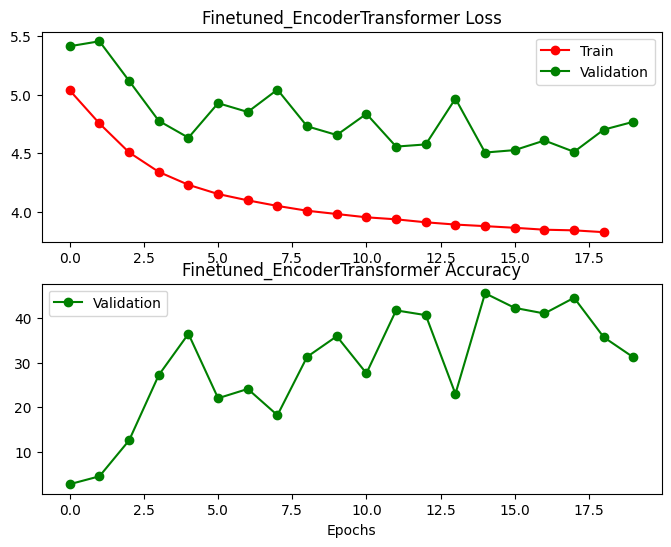

In [165]:
#print(pretrained_signModel)
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
if(torch.cuda.is_available()):
  torch.cuda.empty_cache()
model = SignModel()
prediction_model,test_loader = train(args,model,pretrain=False)

### B) Evaluating Trained Model on Test Set 

In [170]:
# prediction_model.to(device)
# start = time.time()
# test_loss, test_acc_top1,test_acc_top5  = run_validation_step(prediction_model,test_loader)
# time_elapsed = time.time() - start
# print('Model: Encoder Transformer Model, ','Test Loss: %.4f, Top1 Acc: %.1f%%,Top5 Acc: %.1f%%, Time(s): %.2f' % (
#            test_loss, test_acc_top1,test_acc_top5, time_elapsed))

# #### Empty memory ##############
# del prediction_model
# gc.collect()
# torch.cuda.empty_cache()

### finetuned_model.to(device)
prediction_model = SignModel()
prediction_model.to(device)
path = f'outputs/{args.experiment_name}/{args.model_name}_best.pth'
print(path)
best_checkpoint = torch.load(path)
print(best_checkpoint['epoch'],best_checkpoint['metric'])
prediction_model.load_state_dict(best_checkpoint['model_state_dict'])  

start = time.time()

test_loss, test_acc_top1,test_acc_top5  = run_validation_step(prediction_model,test_loader)
time_elapsed = time.time() - start
print('Model: Encoder Transformer Model, ','Test Loss: %.4f, Top1 Acc: %.1f%%,Top5 Acc: %.1f%%, Time(s): %.2f' % (
           test_loss, test_acc_top1,test_acc_top5, time_elapsed))

#### Empty memory ##############
del prediction_model
gc.collect()
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


outputs/ISLR Classification Task from Scratch/EncoderTransformer_best.pth
29 53.61467361450195
Model: Encoder Transformer Model,  Test Loss: 3.8953, Top1 Acc: 81.8%,Top5 Acc: 93.9%, Time(s): 867.18


## 2) Pre-training Encoder-Decoder Model

In [131]:
## Setting for pretraining process

args_dict = {
              #'wlasl_dataset':'/cmp719project-part1/wlasl/estimated_keypoints',
            'wlasl_dataset':'/wlasl-dataset/estimated_keypoints',
            'autsl_dataset': '/autsl-dataset/train_keypoints',
            'train_labels': '/autsl-dataset',
            'max_frames' : 32, # Max number of frames in each file
            "point_dim"  : 42, # 21(L or R landmarks) * 2(x,y)
            'embed_dim'  : 256,
            'num_head'   : 4,
            'num_block'  : 3,
            'batch_size' : 64,  #64 or 32            
            'start_lr': 0.001, #1e-4 #0.0001
            'lr_reduce_factor': 0.1,
            'lr_red_epoch_num': 10,
            'warmup_epochs': 6,
            'momentum':0.9,
            'weight_decay':0.001,
            'dropout':0,
            
            'lmda':0.01, # lambda in paper
            'w_beta':10,
            'w_delta':100,
            'epochs':20,
            'mask_threshold':0.20,
            'model_name': 'pretrained_EncoderDecoderTransformer',
             'resume':True,
            'experiment_name': 'Pretraining with Self-supervized Methods',
            
}
args.update(args_dict)


In [115]:
#if __name__ == '__main__':

model = SignModel()
pretrained_signModel = train(args, model, pretrain = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


** start pre-training **

Epoch 1, Learning Rate: 0.001
Epoch [1/20], Train Loss: 5746.1100, Time (s): 1143
Epoch 2, Learning Rate: 0.001
Epoch [2/20], Train Loss: 170.0287, Time (s): 2234
Epoch 3, Learning Rate: 0.001
Epoch [3/20], Train Loss: 85.9039, Time (s): 3284
Epoch 4, Learning Rate: 0.001
Epoch [4/20], Train Loss: 77.4264, Time (s): 4343
Epoch 5, Learning Rate: 0.001
Epoch [5/20], Train Loss: 34.9205, Time (s): 5429
Epoch 6, Learning Rate: 0.001
Epoch [6/20], Train Loss: 30.6768, Time (s): 6527
Epoch 7, Learning Rate: 0.001
Epoch [7/20], Train Loss: 20.4352, Time (s): 7668
Epoch 8, Learning Rate: 0.001
Epoch [8/20], Train Loss: 16.1262, Time (s): 8792
Epoch 9, Learning Rate: 0.001
Epoch [9/20], Train Loss: 11.6917, Time (s): 9903
Epoch 10, Learning Rate: 0.001
Epoch [10/20], Train Loss: 10.5579, Time (s): 11014
Epoch 11, Learning Rate: 0.001
Epoch [11/20], Train Loss: 7.3859, Time (s): 12094
Epoch 12, Learning Rate: 0.001
Epoch [12/20], Train Loss: 6785.7138, Time (s): 13168
E

In [ ]:
#print(pretrained_signModel)

# 3) Fine-tuning the Pre-trained Model

In [161]:
args_dict = {

            'wlasl_dataset':'/wlasl-dataset/estimated_keypoints',
            'autsl_dataset': '/autsl-dataset/train_keypoints',
            'train_labels': '/autsl-dataset',
            'max_frames' : 64, # Max number of frames in each file
            "point_dim"  : 42, # 21(L or R landmarks) * 2(x,y)
            'embed_dim'  : 256,
            'num_head'   : 4,
            'num_block'  : 3,
            'batch_size' : 32,  #64 or 32
           
            'label_smoothing' : 0.5,
            'start_lr': 0.001, #1e-4 #0.0001
            'lr_reduce_factor': 0.1,
            'lr_red_epoch_num': 10,
            'momentum':0.9,
            'weight_decay':0.0001,
            'dropout':0,
            'mask_threshold':0,
            'epochs':20,
            'num_classes': 226,
            'model_name': 'Finetuned_EncoderTransformer',
            'experiment_name': 'ISLR Classification Task with Finetuned Model'

}
args.update(args_dict)

** start training **

total_length: 28132, train_length: 14066, val_length: 7033, test_length: 7033
Epoch 1, Learning Rate: 0.001
Epoch [1/20], Train Loss: 4.2086, Time (s): 943
Epoch [1/20], Val Loss: 5.2869, Val Acc Top1: 10.8%, Val Acc Top5: 30.2%,  Time(s): 1146.36
Epoch 2, Learning Rate: 0.001
Epoch [2/20], Train Loss: 4.1295, Time (s): 2062
Epoch [2/20], Val Loss: 5.0141, Val Acc Top1: 18.3%, Val Acc Top5: 41.1%,  Time(s): 2223.56
Epoch 3, Learning Rate: 0.001
Epoch [3/20], Train Loss: 4.0764, Time (s): 3105
Epoch [3/20], Val Loss: 4.8495, Val Acc Top1: 26.9%, Val Acc Top5: 54.0%,  Time(s): 3268.91
Epoch 4, Learning Rate: 0.001
Epoch [4/20], Train Loss: 4.0384, Time (s): 4124
Epoch [4/20], Val Loss: 4.7140, Val Acc Top1: 33.4%, Val Acc Top5: 61.4%,  Time(s): 4285.92
Epoch 5, Learning Rate: 0.001
Epoch [5/20], Train Loss: 4.0115, Time (s): 5133
Epoch [5/20], Val Loss: 4.8483, Val Acc Top1: 27.4%, Val Acc Top5: 54.4%,  Time(s): 5292.07
Epoch 6, Learning Rate: 0.001
Epoch [6/20], Tr

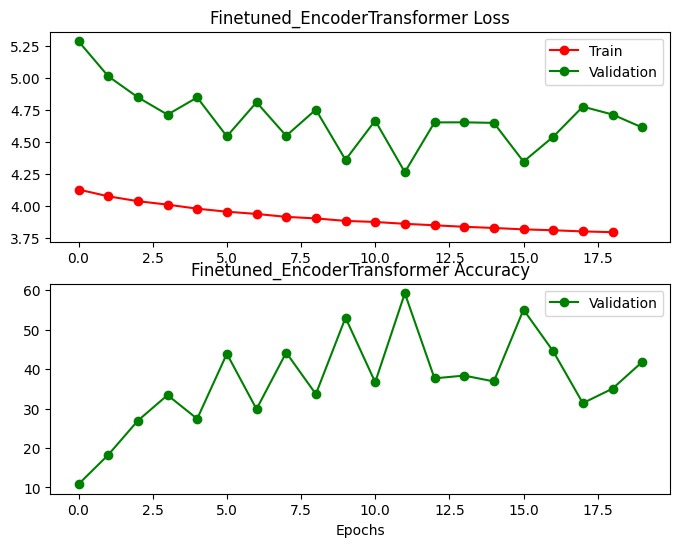

In [135]:


import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
if(torch.cuda.is_available()):
  torch.cuda.empty_cache()
finetuned_model, test_loader = train(args,pretrained_signModel,pretrain=False)

#print(pretrained_signModel)

## 4) Evaluating Finetuned Model on Test Set

In [163]:
### finetuned_model.to(device)
finetuned_model = SignModel()
finetuned_model.to(device)
path = f'outputs/{args.experiment_name}/{args.model_name}_best.pth'
print(path)
best_checkpoint = torch.load(path)
print(best_checkpoint['epoch'],best_checkpoint['metric'])
finetuned_model.load_state_dict(best_checkpoint['model_state_dict'])  

start = time.time()

test_loss, test_acc_top1,test_acc_top5  = run_validation_step(finetuned_model,test_loader)
time_elapsed = time.time() - start
print('Model: Encoder Transformer Model, ','Test Loss: %.4f, Top1 Acc: %.1f%%,Top5 Acc: %.1f%%, Time(s): %.2f' % (
           test_loss, test_acc_top1,test_acc_top5, time_elapsed))

#### Empty memory ##############
del finetuned_model
gc.collect()
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


outputs/ISLR Classification Task with Finetuned Model/Finetuned_EncoderTransformer_best.pth
11 59.24657440185547
Model: Encoder Transformer Model,  Test Loss: 4.0316, Top1 Acc: 73.1%,Top5 Acc: 90.7%, Time(s): 253.95
